Inverse Dynamics
===============
The [inversedynamics](api/kineticstoolkit.inversedynamics.rst) module calculates the proximal forces and moments based on the segment's kinematics and distal forces and moments, based on the general method published in [1].

The results are the forces and moments applied by the distal segment on the
proximal articulation, in the global coordinates system.

.. warning:: This is an experimental module, its API and behaviour may change in the future.

[1] R. Dumas, R. Aissaoui, and J. A. De Guise, "A 3D generic inverse dynamic method using wrench notation and quaternion algebra," Comput Meth Biomech Biomed Eng, vol. 7, no. 3, pp. 159–166, 2004.

In [1]:
import kineticstoolkit.lab as ktk
import matplotlib.pyplot as plt

Loading sample data
-------------------
In this tutorial, we will load propulsion data from a sprint in Wheelchair Basketball. Kinetics were recorded using an instrumented wheel (SmartWheel) and kinematics were recorded using an optoelectronic system (Optitrack). Both are synchronized.

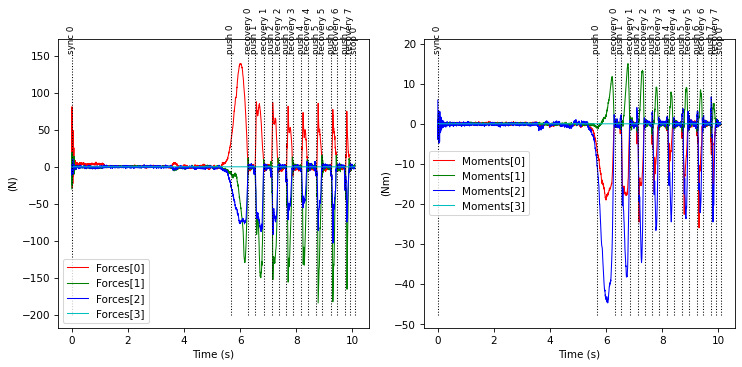

In [2]:
# Load kinetics
kinetics = ktk.load('data/inversedynamics/basketball_kinetics.ktk.zip')

# Change some signs to match (locally): x anterior, # y up, z lateral (right)
kinetics.data['Forces'][:, 0] = -kinetics.data['Forces'][:, 0]
kinetics.data['Forces'][:, 1] = -kinetics.data['Forces'][:, 1]

kinetics.data['Moments'][:, 0] = -kinetics.data['Moments'][:, 0]
kinetics.data['Moments'][:, 1] = -kinetics.data['Moments'][:, 1]

# Keep everything between sync and stop recording events.
kinetics = kinetics.get_ts_between_events('sync', 'stop')

# Look at the data
plt.subplot(1, 2, 1)
kinetics.plot('Forces')
plt.subplot(1, 2, 2)
kinetics.plot('Moments')

{
                     'ArmR_Marker1': <array of shape (1210, 4)>,
                     'ArmR_Marker2': <array of shape (1210, 4)>,
                     'ArmR_Marker3': <array of shape (1210, 4)>,
                     'ArmR_Marker4': <array of shape (1210, 4)>,
                  'BackrestHeightL': <array of shape (1210, 4)>,
                  'BackrestHeightR': <array of shape (1210, 4)>,
      'BackwardFrontAntitipCenterL': <array of shape (1210, 4)>,
      'BackwardFrontAntitipCenterR': <array of shape (1210, 4)>,
       'BackwardRearAntitipCenterL': <array of shape (1210, 4)>,
       'BackwardRearAntitipCenterR': <array of shape (1210, 4)>,
                   'Body_AcromionR': <array of shape (1210, 4)>,
                          'Body_C7': <array of shape (1210, 4)>,
                       'Body_HandR': <array of shape (1210, 4)>,
          'Body_LateralEpicondyleR': <array of shape (1210, 4)>,
                           'ElbowR': <array of shape (1210, 4)>,
               'Externa

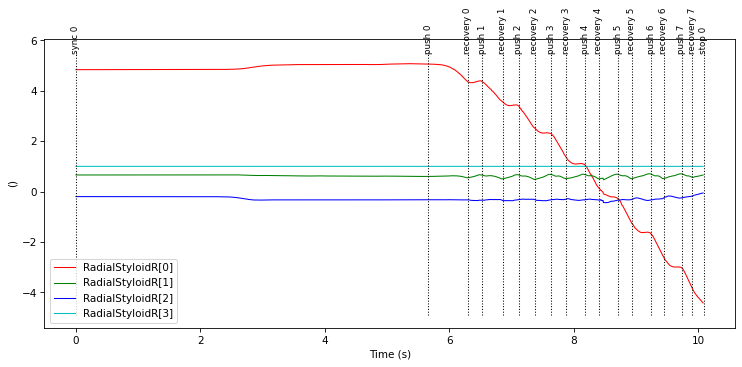

In [3]:
# Load kinematics
kinematics = ktk.load('data/inversedynamics/basketball_kinematics.ktk.zip')['Kinematics']

# Extract markers
markers = kinematics['Markers']
markers.events = kinetics.events

# Extract reference frames
reference_frames = kinematics['ReferenceFrames']
reference_frames.events = kinetics.events

# Keep everything between sync and stop recording events.
markers = markers.get_ts_between_events('sync', 'stop')
reference_frames = reference_frames.get_ts_between_events('sync', 'stop')

# Plot one sample
markers.plot('RadialStyloidR')

# Check what markers are available
markers.data

In [4]:
# Check what reference frames are available
reference_frames.data

{
        'HumerusR': <array of shape (1210, 4, 4)>,
           'Trunk': <array of shape (1210, 4, 4)>,
          'WheelL': <array of shape (1210, 4, 4)>,
          'WheelR': <array of shape (1210, 4, 4)>,
      'Wheelchair': <array of shape (1210, 4, 4)>
}

Put everything relevant into one, synchronized TimeSeries
------------------------------------------------

We will now create a single TimeSeries with every relevant signal. Note that for kinematics, we use `merge` instead of simply copying the data, because kinetics and kinematics have different sampling rate and therefore the data have different lengths. Merging takes care of resampling.

In [5]:
ts_all = ktk.TimeSeries(time=kinetics.time, events=kinetics.events)

# Add reference frames (to put pushrim kinetics in global coordinates,
# and at the end to express shoulder dynamics in local coordinates).
ts_all.merge(
    reference_frames.get_subset(
        ['WheelR', 'HumerusR', 'Trunk']),
    resample=True)

# Add the forces and moments, expressed in global coordinates.
ts_all.data['HubForces'] = ktk.geometry.get_global_coordinates(
    kinetics.data['Forces'],
    ts_all.data['WheelR']
    )

ts_all.data['HubMoments'] = ktk.geometry.get_global_coordinates(
    kinetics.data['Moments'],
    ts_all.data['WheelR']
    )

# Add relevant markers
ts_all.merge(
    markers.get_subset(
        ['RearWheelCenterR', 'RadialStyloidR', 'ElbowR', 'Body_AcromionR']),
    resample=True)

# Check the contents of this TimeSeries
ts_all.data

{
        'Body_AcromionR': <array of shape (2421, 4)>,
                'ElbowR': <array of shape (2421, 4)>,
             'HubForces': <array of shape (2421, 4)>,
            'HubMoments': <array of shape (2421, 4)>,
              'HumerusR': <array of shape (2421, 4, 4)>,
        'RadialStyloidR': <array of shape (2421, 4)>,
      'RearWheelCenterR': <array of shape (2421, 4)>,
                 'Trunk': <array of shape (2421, 4, 4)>,
                'WheelR': <array of shape (2421, 4, 4)>
}

Calculate the force and moments at the wrist
-------------------------------------------
The same calculation is done on every segment, from distal to proximal. We begin with the segment 'Wheel' with the point of force application at the hub (since the measured values are referred at the hub).

In [6]:
# Create an empty TimeSeries
ts = ktk.TimeSeries(time=kinetics.time, events=kinetics.events)

# Add the kinetics data to this TimeSeries
ts.data['DistalForces'] = ts_all.data['HubForces']
ts.data['DistalMoments'] = ts_all.data['HubMoments']

# Add the kinematics data to this TimeSeries.
ts.data['ForceApplicationPosition'] = ts_all.data['RearWheelCenterR']
ts.data['DistalJointPosition'] = ts_all.data['RearWheelCenterR']
ts.data['ProximalJointPosition'] = ts_all.data['RadialStyloidR']

# Check the contents of the resulting TimeSeries.
ts.data

{
                  'DistalForces': <array of shape (2421, 4)>,
           'DistalJointPosition': <array of shape (2421, 4)>,
                 'DistalMoments': <array of shape (2421, 4)>,
      'ForceApplicationPosition': <array of shape (2421, 4)>,
         'ProximalJointPosition': <array of shape (2421, 4)>
}

We now have everything to start computing the forces and moments at the wrist.

In [7]:
# We neglect the inertial properties of the wheel. This is a limit and we could improve on this.
inertial_constants = {'Mass' : 0,
                      'COMProximalRatio' : 0,
                      'GyrationCOMRatio': 0}

### Calculate the COM position of the wheel segment

In [8]:
ts = ktk.inversedynamics.calculate_com_position(ts, inertial_constants)

ts.data

{
                   'COMPosition': <array of shape (2421, 4)>,
                  'DistalForces': <array of shape (2421, 4)>,
           'DistalJointPosition': <array of shape (2421, 4)>,
                 'DistalMoments': <array of shape (2421, 4)>,
      'ForceApplicationPosition': <array of shape (2421, 4)>,
         'ProximalJointPosition': <array of shape (2421, 4)>
}

### Calculate the COM acceleration of the wheel segment

In [9]:
ts = ktk.inversedynamics.calculate_com_acceleration(ts, 'butter', fc=10)

ts.data

{
               'COMAcceleration': <array of shape (2421, 4)>,
                   'COMPosition': <array of shape (2421, 4)>,
                  'DistalForces': <array of shape (2421, 4)>,
           'DistalJointPosition': <array of shape (2421, 4)>,
                 'DistalMoments': <array of shape (2421, 4)>,
      'ForceApplicationPosition': <array of shape (2421, 4)>,
         'ProximalJointPosition': <array of shape (2421, 4)>
}

### Calculate the wheel segment's angles around the global x, y and z axes

In [10]:
ts = ktk.inversedynamics.calculate_segment_angles(ts)

ts.data

{
               'COMAcceleration': <array of shape (2421, 4)>,
                   'COMPosition': <array of shape (2421, 4)>,
                  'DistalForces': <array of shape (2421, 4)>,
           'DistalJointPosition': <array of shape (2421, 4)>,
                 'DistalMoments': <array of shape (2421, 4)>,
      'ForceApplicationPosition': <array of shape (2421, 4)>,
         'ProximalJointPosition': <array of shape (2421, 4)>,
                 'SegmentAngles': <array of shape (2421, 3)>
}

### Calculate the segment's angular velocity and acceleration around the global x, y and z axes

In [11]:
ts = ktk.inversedynamics.calculate_segment_rotation_rates(ts, 'butter', fc=10)

ts.data

{
           'AngularAcceleration': <array of shape (2421, 3)>,
               'AngularVelocity': <array of shape (2421, 3)>,
               'COMAcceleration': <array of shape (2421, 4)>,
                   'COMPosition': <array of shape (2421, 4)>,
                  'DistalForces': <array of shape (2421, 4)>,
           'DistalJointPosition': <array of shape (2421, 4)>,
                 'DistalMoments': <array of shape (2421, 4)>,
      'ForceApplicationPosition': <array of shape (2421, 4)>,
         'ProximalJointPosition': <array of shape (2421, 4)>,
                 'SegmentAngles': <array of shape (2421, 3)>
}

### Finally, calculate the proximal forces and moments

In [12]:
ts = ktk.inversedynamics.calculate_proximal_wrench(ts, inertial_constants)

ts.data

{
           'AngularAcceleration': <array of shape (2421, 3)>,
               'AngularVelocity': <array of shape (2421, 3)>,
               'COMAcceleration': <array of shape (2421, 4)>,
                   'COMPosition': <array of shape (2421, 4)>,
                  'DistalForces': <array of shape (2421, 4)>,
           'DistalJointPosition': <array of shape (2421, 4)>,
                 'DistalMoments': <array of shape (2421, 4)>,
      'ForceApplicationPosition': <array of shape (2421, 4)>,
                'ProximalForces': <array of shape (2421, 4)>,
         'ProximalJointPosition': <array of shape (2421, 4)>,
               'ProximalMoments': <array of shape (2421, 4)>,
              'RadiusOfGyration': <array of shape (2421, 3)>,
                 'SegmentAngles': <array of shape (2421, 3)>
}

### Add the calculated distal forces and moments to the ts_all TimeSeries

In [13]:
ts_all.data['WristForces'] = ts.data['ProximalForces']
ts_all.data['WristMoments'] = ts.data['ProximalMoments']

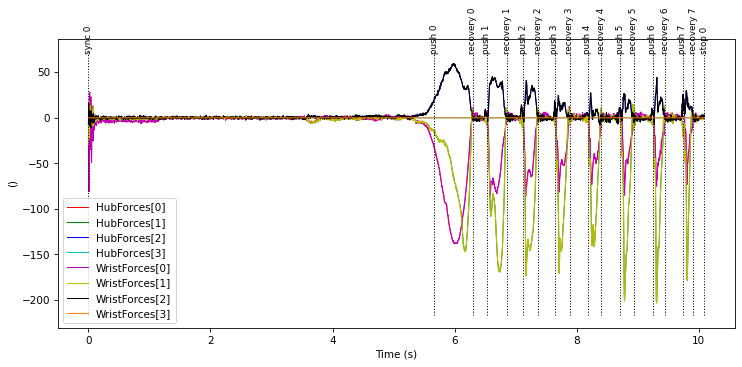

In [14]:
# Plot the hub and wrist forces (identical since
# there were no inertial constants on this segment)
ts_all.plot(['HubForces', 'WristForces'])

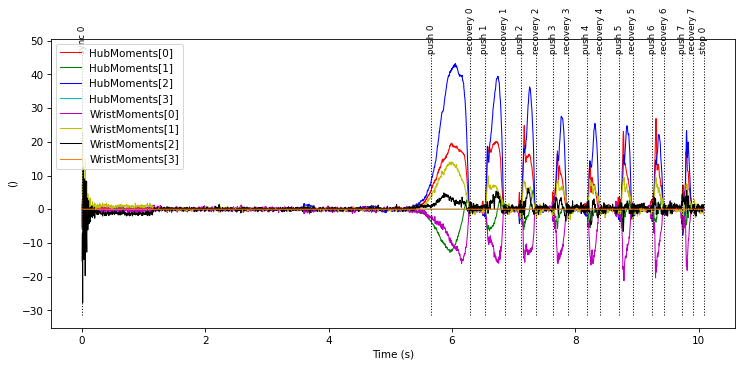

In [15]:
# Plot the hub and wrist moments (not identical
# because of the lever arm between the hub and wrist)
ts_all.plot(['HubMoments', 'WristMoments'])

Calculate the force and moments at the elbow
-------------------------------------------

The method is identical for the other segments. However, for these segments, we will define inertial constants based on anthropometric tables.

In [16]:
inertial_constants = ktk.inversedynamics.get_anthropometrics(
    segment_name='Forearm',
    total_mass=80)

inertial_constants

{
             'COMDistalRatio': 0.57,
           'COMProximalRatio': 0.43,
           'GyrationCOMRatio': 0.303,
        'GyrationDistalRatio': 0.647,
      'GyrationProximalRatio': 0.526,
                       'Mass': 1.28
}

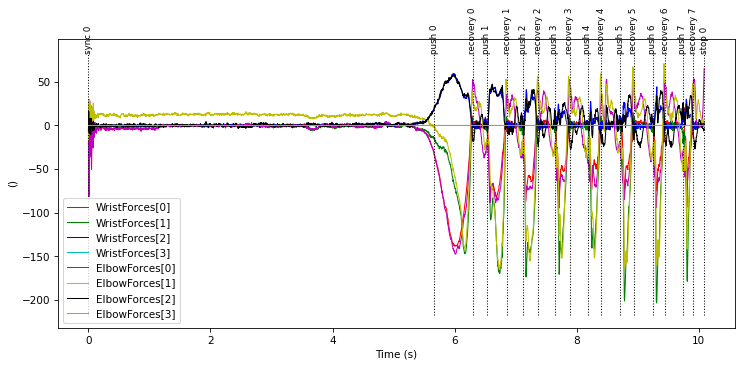

In [17]:
# Create an empty TimeSeries
ts = ktk.TimeSeries(time=kinetics.time, events=kinetics.events)

# Add the kinetics data to this TimeSeries
ts.data['DistalForces'] = ts_all.data['WristForces']
ts.data['DistalMoments'] = ts_all.data['WristMoments']

# Add the kinematics data to this TimeSeries.
ts.data['ForceApplicationPosition'] = ts_all.data['RadialStyloidR']
ts.data['DistalJointPosition'] = ts_all.data['RadialStyloidR']
ts.data['ProximalJointPosition'] = ts_all.data['ElbowR']

# Calculate the COM position and acceleration
ts = ktk.inversedynamics.calculate_com_position(ts, inertial_constants)
ts = ktk.inversedynamics.calculate_com_acceleration(ts, 'butter', fc=10)

# Calculate the segment's angle, angular velocity and angular acceleration
ts = ktk.inversedynamics.calculate_segment_angles(ts)
ts = ktk.inversedynamics.calculate_segment_rotation_rates(ts, 'butter', fc=10)

# Calculate the proximal forces and moments
ts = ktk.inversedynamics.calculate_proximal_wrench(ts, inertial_constants)

# Add the calculated forces and moments to ts_all
ts_all.data['ElbowForces'] = ts.data['ProximalForces']
ts_all.data['ElbowMoments'] = ts.data['ProximalMoments']

# Compare the wrist forces to the elbow forces
ts_all.plot(['WristForces', 'ElbowForces'])

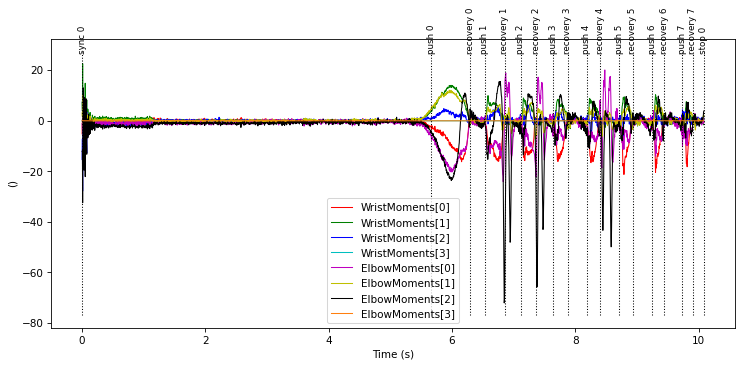

In [18]:
# Compare the wrist moments to the elbow moments
ts_all.plot(['WristMoments', 'ElbowMoments'])

Calculate the force and moments at the shoulder
--------------------------------------------

We proceed exactly as for the elbow.

In [19]:
inertial_constants = ktk.inversedynamics.get_anthropometrics(
    segment_name='UpperArm',
    total_mass=80)

inertial_constants

{
             'COMDistalRatio': 0.564,
           'COMProximalRatio': 0.436,
           'GyrationCOMRatio': 0.322,
        'GyrationDistalRatio': 0.645,
      'GyrationProximalRatio': 0.542,
                       'Mass': 2.24
}

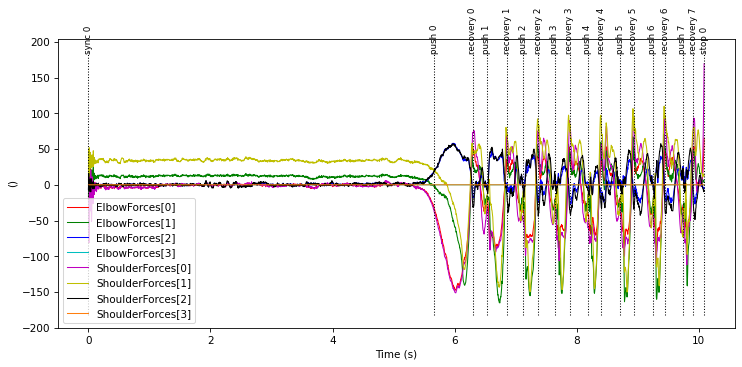

In [20]:
# Create an empty TimeSeries
ts = ktk.TimeSeries(time=kinetics.time, events=kinetics.events)

# Add the kinetics data to this TimeSeries
ts.data['DistalForces'] = ts_all.data['ElbowForces']
ts.data['DistalMoments'] = ts_all.data['ElbowMoments']

# Add the kinematics data to this TimeSeries.
ts.data['ForceApplicationPosition'] = ts_all.data['ElbowR']
ts.data['DistalJointPosition'] = ts_all.data['ElbowR']
ts.data['ProximalJointPosition'] = ts_all.data['Body_AcromionR']

# Calculate the COM position and acceleration
ts = ktk.inversedynamics.calculate_com_position(ts, inertial_constants)
ts = ktk.inversedynamics.calculate_com_acceleration(ts, 'butter', fc=10)

# Calculate the segment's angle, angular velocity and angular acceleration
ts = ktk.inversedynamics.calculate_segment_angles(ts)
ts = ktk.inversedynamics.calculate_segment_rotation_rates(ts, 'butter', fc=10)

# Calculate the proximal forces and moments
ts = ktk.inversedynamics.calculate_proximal_wrench(ts, inertial_constants)

# Add the calculated forces and moments to ts_all
ts_all.data['ShoulderForces'] = ts.data['ProximalForces']
ts_all.data['ShoulderMoments'] = ts.data['ProximalMoments']

# Compare the elbow forces to the shoulder forces
ts_all.plot(['ElbowForces', 'ShoulderForces'])

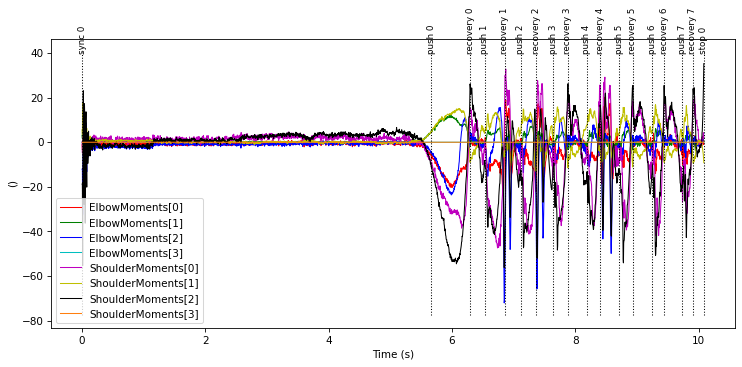

In [21]:
# Compare the elbow moments to the shoulder moments
ts_all.plot(['ElbowMoments', 'ShoulderMoments'])

Get the forces and moments in the correct reference frames
----------------------------------------------------------
Please note that every force and moment we just calculated is expressed in the global reference frame, which is of limited value for interpretation. It is much more useful to express these data in local coordinates. Several conventions may be used, here we will express the shoulder forces in the trunk reference frame, and the shoulder moments in the humeral reference frame.

In [22]:
# Create a new TimeSeries
local_joint_dynamics = ktk.TimeSeries(time=ts_all.time, events=ts_all.events)

# Fill it with the external forces
local_joint_dynamics.data['Forces'] = ktk.geometry.get_local_coordinates(
    ts_all.data['ShoulderForces'],
    ts_all.data['Trunk']
)

# This is the forces applied by the trunk on the humerus. Normally we want the contrary,
# the external forces applied by the humerus on the trunk:
local_joint_dynamics.data['Forces'] = -local_joint_dynamics.data['Forces']

local_joint_dynamics.data['Moments'] = ktk.geometry.get_local_coordinates(
    ts_all.data['ShoulderMoments'],
    ts_all.data['HumerusR']
)

### Local forces

Let's plot the shoulder forces in the trunk reference frame:

External forces in the trunk reference frame:


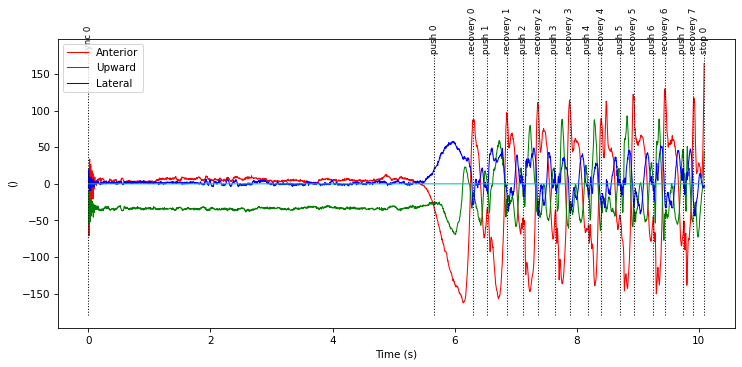

In [23]:
local_joint_dynamics.plot('Forces')
plt.legend(['Anterior', 'Upward', 'Lateral'])
print('External forces in the trunk reference frame:')

### Local moments

Net internal shoulder moments:


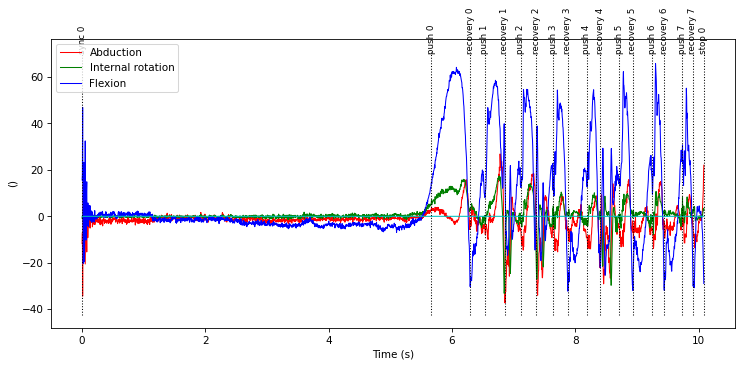

In [24]:
local_joint_dynamics.plot('Moments')
plt.legend(['Abduction', 'Internal rotation', 'Flexion'])
print('Net internal shoulder moments:')

For more information on inversedynamics, please check the [API Reference for the inversedynamics module](api/kineticstoolkit.inversedynamics.rst).